In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import camb
import scipy.linalg
from camb import model, initialpower
from camb.dark_energy import DarkEnergyPPF, DarkEnergyFluid

In [2]:
#Set up the ell range
camb_ell_min          = 2#30
camb_ell_max          = 5000
camb_ell_range        = camb_ell_max  - camb_ell_min 

#load test data
testing_samples=np.load('parametersamples/cos_pkc_T128.npy',allow_pickle=True)[10000:]

testing_data_vectors=np.load('datavectors/Planck128/cos_pkc_T128_TT_acc.npy',allow_pickle=True)[10000:,:4998]

In [3]:
#set device
#I prefer using CPU for model usage after training
device = torch.device('cuda:0')

#set the number of layers and internal dimension of the ResMLP blocks
Nlayer=3
intdim=4

In [4]:

class Supact(nn.Module):
    def __init__(self, in_size):
        super(Supact, self).__init__()
        
        self.gamma = nn.Parameter(torch.ones(in_size))
        self.beta = nn.Parameter(torch.zeros(in_size))

    def forward(self, x):
        inv = (1+torch.exp(-1*torch.mul(self.beta,x))).pow_(-1)
        fac = 1-self.gamma
        mult = self.gamma + torch.mul(inv,fac)
        return torch.mul(mult,x)

class Affine(nn.Module):
    def __init__(self):
        super(Affine, self).__init__()

        # This function is designed for the Neuro-network to learn how to normalize the data between
        # layers. we will initiate gains and bias both at 1 
        self.gain = nn.Parameter(torch.ones(1))

        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        return x * self.gain + self.bias


class ResBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(ResBlock, self).__init__()
        
        if in_size != out_size: 
            self.skip = nn.Linear(in_size, out_size, bias=False) # we don't consider this. remove?
        else:
            self.skip = nn.Identity()

        self.layer1 = nn.Linear(in_size, out_size)
        self.layer2 = nn.Linear(out_size, out_size)

        self.norm1 = Affine()
        self.norm2 = Affine()

        self.act1 = Supact(in_size)#nn.Tanh()#nn.ReLU()#
        self.act2 = Supact(in_size)#nn.Tanh()#nn.ReLU()#

    def forward(self, x):
        xskip = self.skip(x)

        o1 = self.act1(self.layer1(self.norm1(x)))
        o2 = self.act2(self.layer2(self.norm2(o1))) + xskip

        return o2


class ResMLP(nn.Module):

    def __init__(self, input_dim, output_dim, int_dim, N_layer):

        super(ResMLP, self).__init__()

        modules=[]

        # Def: we will set the internal dimension as multiple of 128 (reason: just simplicity)
        int_dim = int_dim * 128

        # Def: we will only change the dimension of the datavector using linear transformations  
        modules.append(nn.Linear(input_dim, int_dim))
        
        # Def: by design, a pure block has the input and output dimension to be the same
        for n in range(N_layer):
            # Def: This is what we defined as a pure MLP block
            # Why the Affine function?
            #   R: this is for the Neuro-network to learn how to normalize the data between layer
            modules.append(ResBlock(int_dim, int_dim))
            modules.append(Supact(int_dim))
        
        # Def: the transformation from the internal dimension to the output dimension of the
        #      data vector we intend to emulate
        
        modules.append(nn.Linear(int_dim, output_dim))
        modules.append(Affine())
        # NN.SEQUENTIAL is a PYTHORCH function DEFINED AT: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        # This function stacks up layers in the modules-list in sequence to create the whole model
        self.resmlp =nn.Sequential(*modules)#

    def forward(self, x):
        #x is a cosmological parameter set you feed in the model
        out = self.resmlp(x)

        return out



In [5]:
#set up and load models
model = ResMLP(input_dim=9,output_dim=96,int_dim=intdim,N_layer=Nlayer)
model.to(device)
model = nn.DataParallel(model)

In [6]:
covinv=np.load('extra/cosvarinvTT.npy',allow_pickle=True)[:camb_ell_range,:camb_ell_range]


In [7]:
PATH = "./trainedemu5000plkres/chiTTAstauresrescaleplk96i"+str(intdim)+'l'+str(Nlayer)
extrainfo=np.load("extra/extrainfo_plk_tt_third_T256_96.npy",allow_pickle=True)
X_mean=torch.Tensor(extrainfo.item()['X_mean']).to(device)
X_std=torch.Tensor(extrainfo.item()['X_std']).to(device)
Y_mean=torch.Tensor(extrainfo.item()['Y_mean']).to(device)
Y_std=torch.Tensor(extrainfo.item()['Y_std']).to(device)
Y_mean2=torch.Tensor(extrainfo.item()['Y_mean2']).to(device)
Y_std2=torch.Tensor(extrainfo.item()['Y_std2']).to(device)
model.load_state_dict(torch.load(PATH+'.pt',map_location=device))
model.eval()

DataParallel(
  (module): ResMLP(
    (resmlp): Sequential(
      (0): Linear(in_features=9, out_features=512, bias=True)
      (1): ResBlock(
        (skip): Identity()
        (layer1): Linear(in_features=512, out_features=512, bias=True)
        (layer2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): Affine()
        (norm2): Affine()
        (act1): Supact()
        (act2): Supact()
      )
      (2): Supact()
      (3): ResBlock(
        (skip): Identity()
        (layer1): Linear(in_features=512, out_features=512, bias=True)
        (layer2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): Affine()
        (norm2): Affine()
        (act1): Supact()
        (act2): Supact()
      )
      (4): Supact()
      (5): ResBlock(
        (skip): Identity()
        (layer1): Linear(in_features=512, out_features=512, bias=True)
        (layer2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): Affine()
        (norm2): Affin

In [8]:
def predict(X):
    with torch.no_grad():
        X_norm=((X.float() - X_mean.float()) / X_std.float())
        X_norm[:,6:]=0
        #print(X_norm)
        pred=model(X_norm.to(device))
        #print(pred.dtype)
        
        M_pred=pred.to(device)
        y_pred = (M_pred.float() *Y_std2.float()+Y_mean2.float()).cpu().numpy()
        
    return y_pred
transform_matrix=np.load('extra/PCAmat_T256_tt_third.npy',allow_pickle=True)#PCA matrix loaded
def unnormalize(y,X):
    y_pred=np.dot(y,transform_matrix)*Y_std.cpu().float().numpy()+Y_mean.cpu().float().numpy()
    for i in range(len(y_pred)):
        y_pred[i]=y_pred[i]*(np.exp(X[i,5].cpu().float().numpy()))/(np.exp(2*X[i,3].cpu().float().numpy()))
    return y_pred

#just a small trial to see if the pipline works
testing_samples=torch.Tensor(testing_samples).to(device)

testing_results=predict(testing_samples)

pred=unnormalize(testing_results,testing_samples)

In [9]:
#computing chi2
diff=testing_data_vectors- pred

loss1 = np.diag(diff@covinv@diff.T)


print(r'mean $\chi^2=$',np.mean(loss1))
print(r'median $\chi^2=$',np.median(loss1))

mean $\chi^2=$ 6.020426013992199
median $\chi^2=$ 1.1050876007265034


In [10]:
print(r'$f(\chi^2>1)=$',len([1 for i in loss1 if i > 1])/len(loss1))

$f(\chi^2>1)=$ 0.519


In [11]:
print(r'$f(\chi^2>0.2)=$',len([1 for i in loss1 if i > 0.2])/len(loss1))

$f(\chi^2>0.2)=$ 0.8414


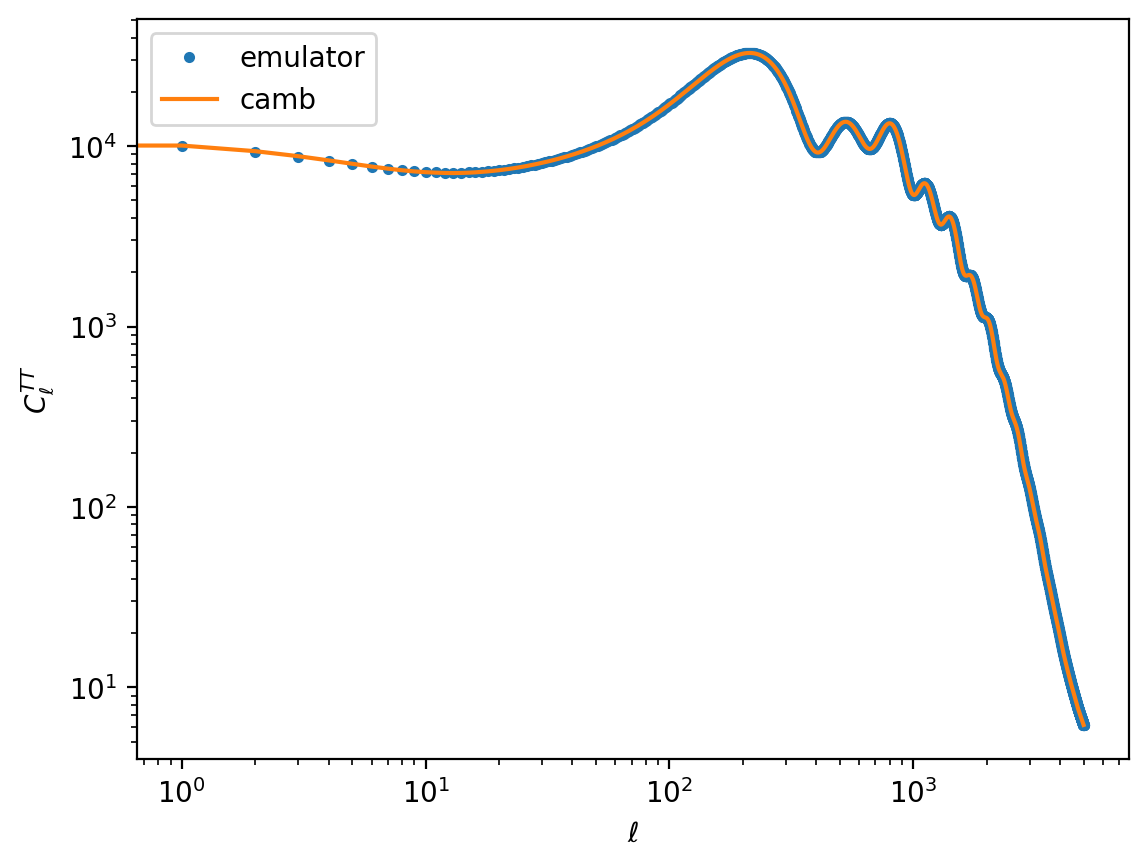

In [12]:
#Plot out one example to compare the difference between emulator and camb

ell=np.arange(2,5000,1)
plt.plot(pred[1000]*ell*(ell+1),'.',label='emulator')
plt.plot(testing_data_vectors[1000]*ell*(ell+1),label='camb')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}^{TT}$')
plt.legend()


In [13]:
#computing distribution of error on each mode for a shade plot
chiell=abs(pred-testing_data_vectors)*np.sqrt(np.diag(covinv))*100

q1=[]
q2=[]
q3=[]
for i in range(4998):
    sorteddif=np.sort(chiell[:,i])
    q1.append(sorteddif[int(8090*0.68-1)])
    q2.append(sorteddif[int(8090*0.95-1)])
    q3.append(sorteddif[int(8090*0.99-1)])
q1=np.array(q1)
q2=np.array(q2)
q3=np.array(q3)

Text(0.5, 0, '$\\ell$')

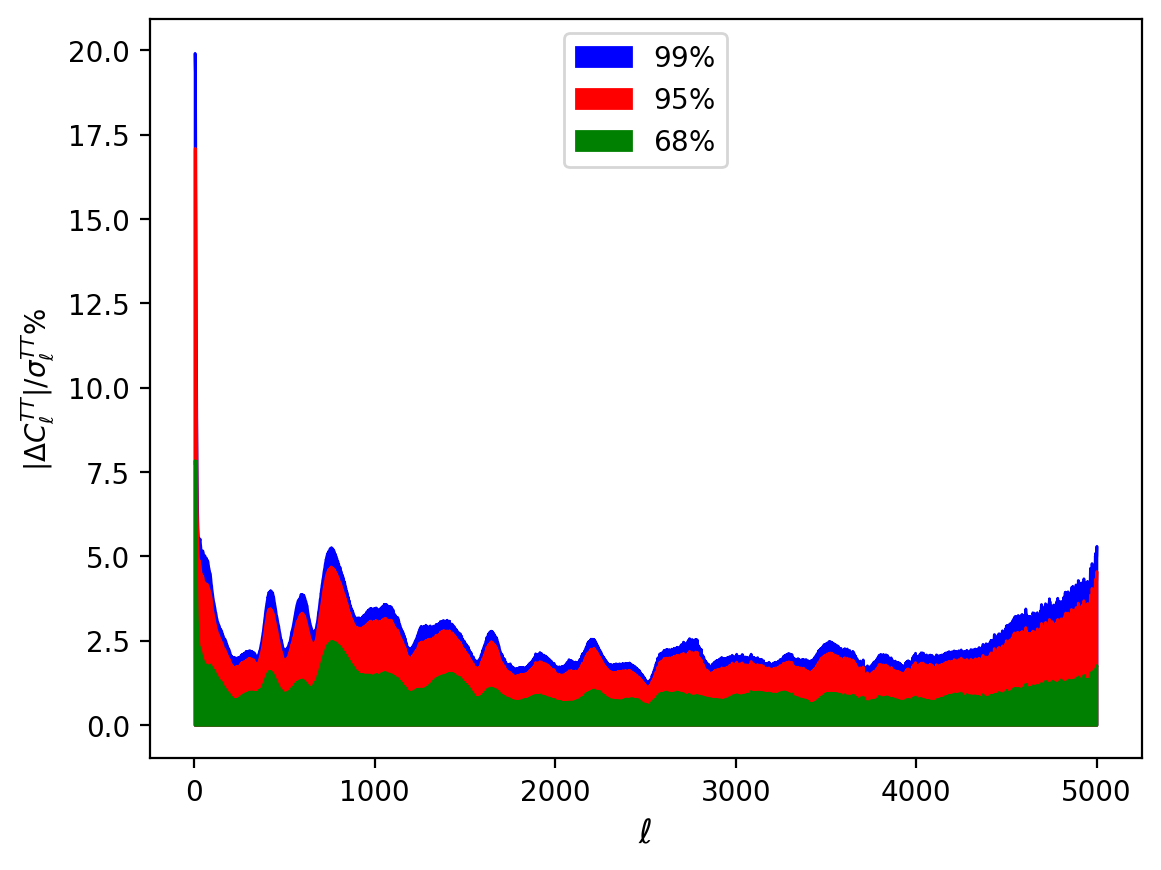

In [14]:
ell=np.arange(2,5000,1)

plt.fill_between(ell, q3, color='blue',label=r'$99\%$')
plt.fill_between(ell, q2, color='red',label=r'$95\%$')
plt.fill_between(ell, q1, color='green',label=r'$68\%$')
plt.legend(loc=9)
plt.ylabel(r'$|\Delta C_{\ell}^{TT}|/\sigma_{\ell}^{TT}$'+r'$\%$')
plt.xlabel(r'$\ell$',fontsize=12)
